In [438]:
import sys
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.special import logsumexp
from scipy.stats import gaussian_kde
sys.path.append('vbpi-torch/rooted')
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


import torch
from dataManipulation import *
from treeManipulation import *
from utils import tree_summary, summary, summary_raw, get_support_info
from vbpi import VBPI

In [439]:
sns.set_style("whitegrid")  # Options: white, dark, whitegrid, darkgrid, ticks
sns.set_palette("muted")    # Options: deep, muted, bright, pastel, dark, colorblind

In [440]:
import pandas as pd

#from autograd_gamma import gamma, gammainc, gammaincc, gammaincln, gammainccln

import matplotlib.pyplot as plt
from copy import deepcopy
from itertools import product
from itertools import combinations
import pickle

from io import StringIO
from Bio import Phylo

from tree_torch import Tree
from SLCVI_torch import SLCVI

import warnings
warnings.filterwarnings('ignore')

np.random.seed(0)

# Plot:
 - time / likelihood evaluation vs number of taxa
 - time / likelihood evaluation vs number of sites

In [441]:
datasets = ["DS14_3","DS14_6","DS14_12","DS14_24","DS14_48","DS14_72"]#["DS"+str(i) for i in range(1,12)]

# VBPI
sec_per_iter = {}
VBPI_sec_per_iter = {}
ntaxa = {}
ngenes = {}
legend = datasets

for DS in datasets:
    print(DS)
    
    ### get ntaxa and ngenes
    data_file = '../dat/'+DS+'/'+DS+'.pickle'
    with open(data_file, 'rb') as f:
        data = pickle.load(f)

    ntaxa[DS] = len(data)
    ngenes[DS] = len(data[list(data.keys())[0]])
    
    ### get iters per second for VBPI
    for bs in ["10","20"]:

        lb_star = -np.infty

        for ss in ["0.01","0.001","0.0001","1e-05"]:
            VBPI_dir = '../results/'+DS+'/'
            VBPI_pref = "mcmc_vimco_%s_%s_psp_fixed_pop_fixed_rate_"%(bs,ss)
            files = [x for x in os.listdir(VBPI_dir) if x.startswith(VBPI_pref)]
            try:
                VBPI_runtimes0 = np.load(VBPI_dir+max([x for x in files if x.endswith("_run_time.npy")]))
                VBPI_lbs0 = np.load(VBPI_dir+max([x for x in files if x.endswith("_test_lb.npy")]))
                VBPI_iters0 = np.load(VBPI_dir+max([x for x in files if x.endswith("_iters.npy")]))
            except:
                continue

            if max(VBPI_lbs0) > lb_star:
                VBPI_sec_per_iter[DS] = VBPI_runtimes0[-1] / (10 * VBPI_iters0[-1])
                lb_star = max(VBPI_lbs0)
                
    ### get seconds per iter for my method
    ELBO_star = -np.infty
    sec_per_iter[DS] = {}

    for model in ["reinforce","reparam","VIMCO"]:
        
        sec_per_iter[DS][model] = None
        ELBO_star = -np.infty

        for ss in [0.03]:
            for rs in range(1):
                optim_dir = '../results/'+DS+'/'
                optim_pref = DS+'_'+model+'_'+str(ss)+'_'+str(rs)
                files = [x for x in os.listdir(optim_dir) if x.startswith(optim_pref)]
                if not files:
                    print(optim_pref + " does not exist. Continuing...")
                    continue

                fname = optim_dir + max(files)
                print(fname)

                with open(fname, 'rb') as f:
                    optim0 = pickle.load(f)
    
                if optim0.ELBO_ests[-1] > ELBO_star:
                    sec_per_iter[DS][model] = optim0.run_times[-1] / (10 * (optim0.epochs[-1]))
                    ELBO_star = optim0.ELBO_ests[-1]

DS14_3
../results/DS14_3/DS14_3_reinforce_0.03_0_2025_01_24_18_57_46.pickle
../results/DS14_3/DS14_3_reparam_0.03_0_2025_01_24_18_56_55.pickle
../results/DS14_3/DS14_3_VIMCO_0.03_0_2025_01_24_18_58_19.pickle
DS14_6
../results/DS14_6/DS14_6_reinforce_0.03_0_2025_01_24_18_19_48.pickle
../results/DS14_6/DS14_6_reparam_0.03_0_2025_01_24_18_17_31.pickle
../results/DS14_6/DS14_6_VIMCO_0.03_0_2025_01_24_18_21_24.pickle
DS14_12
../results/DS14_12/DS14_12_reinforce_0.03_0_2025_01_24_19_56_53.pickle
../results/DS14_12/DS14_12_reparam_0.03_0_2025_01_24_19_49_50.pickle
../results/DS14_12/DS14_12_VIMCO_0.03_0_2025_01_24_20_02_15.pickle
DS14_24
../results/DS14_24/DS14_24_reinforce_0.03_0_2025_01_24_18_34_10.pickle
../results/DS14_24/DS14_24_reparam_0.03_0_2025_01_24_18_23_01.pickle
../results/DS14_24/DS14_24_VIMCO_0.03_0_2025_01_24_18_45_30.pickle
DS14_48
../results/DS14_48/DS14_48_reinforce_0.03_0_2025_01_24_20_20_45.pickle
../results/DS14_48/DS14_48_reparam_0.03_0_2025_01_24_20_07_46.pickle
../res

In [442]:
colors = {"BEAST":plt.cm.tab10(0),
          "VBPI":plt.cm.tab10(1),
          "reinforce":plt.cm.tab10(2),
          "reparam":plt.cm.tab10(3),
          "VIMCO":plt.cm.tab10(4)}

###

plt.scatter([ntaxa[x] for x in VBPI_sec_per_iter.keys()],
            [(1000*VBPI_sec_per_iter[x]) for x in VBPI_sec_per_iter.keys()],
            color = colors["VBPI"])
for model in ["reinforce","reparam"]:
    plt.scatter([ntaxa[x] for x in datasets],
                [(1000*sec_per_iter[x][model]) for x in datasets],
               color = colors[model])
    
plt.ylabel("Seconds per 1000 Iterations")
plt.xlabel("ntaxa")
plt.legend(["VBPI","reinforce","reparam","VIMCO"])
plt.yscale("log")
plt.xscale("log")
plt.show()

###

def dlogy_dlogx(y,x):
    return [np.log(y[i+1])-np.log(y[i]) / np.log(x[i+1])-np.log(x[i]) for i in range(len(y)-1)]

plt.scatter([ntaxa[x] for x in VBPI_sec_per_iter.keys()[1:]],
             dlogy_dlogx(list(VBPI_sec_per_iter.values()),list(ntaxa.values()))
             color = colors["VBPI"])
for model in ["reinforce","reparam"]:
    plt.scatter([ntaxa[x] for x in VBPI_sec_per_iter.keys()[1:]],
                dlogy_dlogx(list(VBPI_sec_per_iter.values()),list(ntaxa.values()))
    plt.scatter([ntaxa[x] for x in datasets[1:]],
                dlogy_dlogx([(1000*sec_per_iter[x][model]) for x in datasets],
                            [ntaxa[x] for x in datasets])
               color = colors[model])
    
plt.ylabel("Seconds per 1000 Iterations")
plt.xlabel("ntaxa")
plt.legend(["VBPI","reinforce","reparam","VIMCO"])
plt.xscale("log")
plt.show()

###
                
plt.scatter([ngenes[x] for x in VBPI_sec_per_iter.keys()],
            [(1000*VBPI_sec_per_iter[x]) for x in VBPI_sec_per_iter.keys()],
           color = colors["VBPI"])    
for model in ["reinforce","reparam"]:
    plt.scatter([ngenes[x] for x in datasets],
                [(1000*sec_per_iter[x][model]) for x in datasets],
               color = colors[model])
    
plt.ylabel("Seconds per 1000 Iterations")
plt.xlabel("ngenes")
plt.legend(["VBPI","reinforce","reparam","VIMCO"])
plt.show()

plt.scatter([ntaxa[x] for x in VBPI_sec_per_iter.keys()],
            [(sec_per_iter[x]["reinforce"]/VBPI_sec_per_iter[x]) for x in VBPI_sec_per_iter.keys()],
            color = colors["reinforce"])

plt.scatter([ntaxa[x] for x in VBPI_sec_per_iter.keys()],
            [(sec_per_iter[x]["reparam"]/VBPI_sec_per_iter[x]) for x in VBPI_sec_per_iter.keys()],
            color = colors["reparam"])

plt.ylabel("Ratio of Seconds per Iteration")
plt.xlabel("ntaxa")
plt.legend(["reinforce","reparam"])
plt.show()

plt.scatter([ntaxa[x] for x in datasets],
            [ngenes[x] for x in datasets])             
plt.ylabel("ntaxa")
plt.xlabel("ngenes")
plt.show()


SyntaxError: invalid syntax (3295903516.py, line 31)

In [379]:
dlogy_dlogx([(1000*sec_per_iter[x][model]) for x in datasets],
                            [ntaxa[x] for x in datasets])

[-1.4366750548652463,
 -1.9013361881979307,
 -1.2451505171779158,
 0.18540391695769687,
 0.4764922660314377]

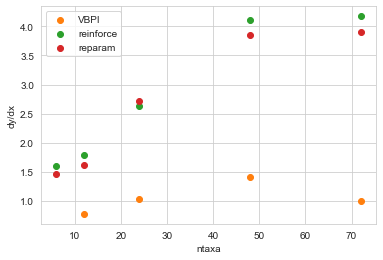

In [431]:
def dlogy_dlogx(y,x):
    return [(np.log(y[i+1])-np.log(y[i])) / (np.log(x[i+1])-np.log(x[i])) for i in range(len(y)-1)]

plt.scatter([ntaxa[x] for x in list(VBPI_sec_per_iter.keys())[1:]],
             dlogy_dlogx(list(VBPI_sec_per_iter.values()),list(ntaxa.values())),
             color = colors["VBPI"])
for model in ["reinforce","reparam"]:
    plt.scatter([ntaxa[x] for x in datasets[1:]],
                dlogy_dlogx([(1000*sec_per_iter[x][model]) for x in datasets],
                            [ntaxa[x] for x in datasets]),
                color = colors[model])
    
plt.ylabel("dy/dx")
plt.xlabel("ntaxa")
plt.legend(["VBPI","reinforce","reparam","VIMCO"])
#plt.xscale("log")
plt.savefig("../plt/dydx_v_ntaxa")
plt.show()

In [17]:
x = np.array([ntaxa[x] for x in VBPI_sec_per_iter.keys()])
y = np.array([VBPI_sec_per_iter[x] for x in VBPI_sec_per_iter.keys()])
print(np.polyfit(np.log10(x), np.log10(y), 1))

x = np.array([ntaxa[x] for x in datasets])
y = np.array([sec_per_iter[x]["reinforce"] for x in datasets])
print(np.polyfit(np.log10(x), np.log10(y), 1))

[ 1.17777644 -4.41298373]
[ 2.73866194 -6.17940118]


# Plot by Dataset

In [433]:
data_set = "DS1"
pop_size = 5.0 # exponential parameter for constant pop size prior

# initialize models
models = {"reinforce": {},
          "reparam": {},
          "VIMCO": {},
          "VBPI": {}}

data_file = '../dat/'+data_set+'/'+data_set+'.pickle'

# models
models = ["reparam","reinforce","VIMCO","BEAST","VBPI"]

# Beast file
BEAST_pref = '../dat/'+data_set+'/'+data_set+'_MLL_'
BEAST_burnin = 250000

# VPBI files
VBPI_dir = '../results/'+data_set+'/'

# Requirements for VBPI

In [434]:
# load the sequence data and estimate the subsplit support
data, taxa = loadData('../dat/'+data_set+'/'+data_set+'.nexus', 'nexus')
mcmc_support_trees_dict, mcmc_support_trees_wts = summary('../dat/'+data_set+'/'+data_set+'_fixed_pop_support_short_run', 'nexus', burnin=250)
rootsplit_supp_dict, subsplit_supp_dict = get_support_info(taxa, mcmc_support_trees_dict)
#del mcmc_support_trees_dict, mcmc_support_trees_wts

In [435]:
# load the ground truth
#mcmc_sampled_trees_dict, mcmc_sampled_trees_wts, _ = tree_summary('../dat/DS1/DS1_fixed_pop_golden_run.trees', 'nexus', burnin=25001)
emp_tree_freq = None#{mcmc_sampled_trees_dict[tree_id]: tree_wts for tree_id, tree_wts in sorted(mcmc_sampled_trees_wts.items(), key=lambda x:x[1], reverse=True)}
sample_info = [0.0 for taxon in taxa]
#del mcmc_sampled_trees_dict, mcmc_sampled_trees_wts

In [436]:
# set up the model
VBPI_models = {}
VBPI_models["10"] = VBPI(taxa, rootsplit_supp_dict, subsplit_supp_dict, data, pden=np.ones(4)/4., subModel=('JC', 1.0),
             emp_tree_freq=emp_tree_freq, root_height_offset=0.0, clock_rate=1.0, psp=True,
             sample_info=sample_info, coalescent_type='fixed_pop', clock_type='fixed_rate',
             log_pop_size_offset=math.log(5.0))

VBPI_models["20"] = VBPI(taxa, rootsplit_supp_dict, subsplit_supp_dict, data, pden=np.ones(4)/4., subModel=('JC', 1.0),
             emp_tree_freq=emp_tree_freq, root_height_offset=0.0, clock_rate=1.0, psp=True,
             sample_info=sample_info, coalescent_type='fixed_pop', clock_type='fixed_rate',
             log_pop_size_offset=math.log(5.0))

# Load in the relevant files

0
2
0
2
mcmc_vimco_10_0.001_psp_fixed_pop_fixed_rate_2024-12-18_11-16-45.pt
0
2
0
2
mcmc_vimco_20_0.001_psp_fixed_pop_fixed_rate_2024-12-20_14-06-29.pt


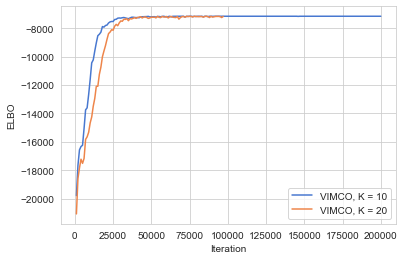

In [437]:
# VBPI
VBPI_runtimes = {}
VBPI_lbs = {}
VBPI_iters = {}

legend = []

for bs in ["10","20"]:
    
    VBPI_runtimes[bs] = None
    VBPI_lbs[bs] = None
    VBPI_iters[bs] = None
    lb_star = -np.infty
    file_star = None
    
    for ss in ["0.003","0.001","0.0003","0.0001"]:
    #for ss in ["1e-05"]:
        VBPI_pref = "mcmc_vimco_%s_%s_psp_fixed_pop_fixed_rate_"%(bs,ss)
        files = [x for x in os.listdir(VBPI_dir) if x.startswith(VBPI_pref)]
        files = [x for x in files if x.endswith(".pt")]
        #files = [x for x in files if "2025-01-25_20-2" in x]
        files = [x for x in files if not "2025-01-22" in x]
        files = [x for x in files if not "2025-01-23" in x]
        files = [x for x in files if not "2025-01-24" in x]
        files = [x for x in files if not "2025-01-25" in x]
        
        print(len(files))
        
        for file in files:
        
            VBPI_runtimes0 = np.load(VBPI_dir+file.replace(".pt","_run_time.npy"))
            VBPI_lbs0 = np.load(VBPI_dir+file.replace(".pt","_test_lb.npy"))
            VBPI_iters0 = np.load(VBPI_dir+file.replace(".pt","_iters.npy"))

            if max(VBPI_lbs0) > lb_star:
                VBPI_runtimes[bs] = VBPI_runtimes0
                VBPI_lbs[bs] = VBPI_lbs0
                VBPI_iters[bs] = VBPI_iters0
                VBPI_models[bs].load_from(VBPI_dir+max([x for x in files if x.endswith(".pt")]))
                lb_star = max(VBPI_lbs0)
                file_star = file
        
            
    print(file_star)
    plt.plot(VBPI_iters[bs],VBPI_lbs[bs])
    plt.xlabel("Iteration")
    legend.append("VIMCO, K = %s"%(bs))  

plt.ylabel("ELBO")
plt.legend(legend)

In [395]:
# BEAST
def load_beast(data_set,i,burnin):
    df = pd.read_csv('../dat/'+data_set+'/'+data_set+'_fixed_pop_MLL_%d.log'%i, 
                     sep = '\t',skiprows=[0,1,2])
    df = df[df.state > burnin]
    return df

BEAST_data = pd.concat([load_beast(data_set,i,BEAST_burnin) for i in range(1,11)])
BEAST_MLLs = []

# extract MLL from beast log
for i in range(1,11):
    with open('../dat/'+data_set+'/'+data_set+"_MLL_%d.txt"%i, "r") as text_file:
        line = text_file.readlines()[-4]
    ind = np.where([not x in "-1234567890." for x in line])[0][-2]
    BEAST_MLLs.append(float(line[(ind+1):-1]))

In [396]:
# my models
optims = {}
settings = {}
ELBO_star = -np.infty
fname_star = None
ELBO_min = np.infty
ELBO_max = -np.infty

for model in ["reinforce","reparam","VIMCO"]:
    
    optims[model] = None
    ELBO_star = -np.infty
    
    for ss in [0.03,0.01,0.003]:
    
        for rs in range(1):
            
            optim_dir = '../results/'+data_set+'/'
            optim_pref = data_set+'_'+model+'_'+str(ss)+'_'+str(rs)
            files = [x for x in os.listdir(optim_dir) if x.startswith(optim_pref)]
            #files = [x for x in files if not "2025_01_23" in x]
            #files = [x for x in files if not "2025_01_24" in x]
            #files = [x for x in files if not "2025_01_25" in x]
            files = [x for x in files if "2025_01_25_00" in x]
            
            if not files:
                print(optim_pref + " does not exist. Continuing...")
                continue
            
            fname = optim_dir + max(files)
    
            with open(fname, 'rb') as f:
                optim0 = pickle.load(f)
            
            if optim0.ELBO_ests[-1] > ELBO_star:
                optims[model] = optim0
                settings[model] = (ss,rs)
                ELBO_star = optim0.ELBO_ests[-1]
                fname_star = fname
                
            #print(model)
            #print(ss)
            #print(rs)
            #print(max(optim0.ELBO_ests))
            #print("")
                
    print(fname_star)
    
    if max(optims[model].ELBO_ests) > ELBO_max:
        ELBO_max = max(optims[model].ELBO_ests)

    if min(optims[model].ELBO_ests) < ELBO_min:
        ELBO_min = min(optims[model].ELBO_ests)

DS14_reinforce_0.01_0 does not exist. Continuing...
DS14_reinforce_0.003_0 does not exist. Continuing...
../results/DS14/DS14_reinforce_0.03_0_2025_01_25_00_09_40.pickle
DS14_reparam_0.01_0 does not exist. Continuing...
DS14_reparam_0.003_0 does not exist. Continuing...
../results/DS14/DS14_reparam_0.03_0_2025_01_25_00_09_36.pickle
DS14_VIMCO_0.01_0 does not exist. Continuing...
DS14_VIMCO_0.003_0 does not exist. Continuing...
../results/DS14/DS14_VIMCO_0.03_0_2025_01_25_00_09_45.pickle


In [410]:
[i*10 for i in range(len(optims["reinforce"].epochs))]

[0,
 10,
 20,
 30,
 40,
 50,
 60,
 70,
 80,
 90,
 100,
 110,
 120,
 130,
 140,
 150,
 160,
 170,
 180,
 190,
 200,
 210,
 220,
 230,
 240,
 250,
 260,
 270,
 280,
 290,
 300,
 310,
 320,
 330,
 340,
 350,
 360,
 370,
 380,
 390,
 400,
 410,
 420,
 430,
 440,
 450,
 460,
 470,
 480,
 490,
 500,
 510,
 520,
 530,
 540,
 550,
 560,
 570,
 580,
 590,
 600,
 610,
 620,
 630,
 640,
 650,
 660,
 670,
 680,
 690,
 700,
 710,
 720,
 730,
 740,
 750,
 760,
 770,
 780,
 790,
 800,
 810,
 820,
 830,
 840,
 850,
 860,
 870,
 880,
 890,
 900,
 910,
 920,
 930,
 940,
 950,
 960,
 970,
 980,
 990,
 1000,
 1010,
 1020,
 1030,
 1040,
 1050,
 1060,
 1070,
 1080,
 1090,
 1100,
 1110,
 1120,
 1130,
 1140,
 1150,
 1160,
 1170,
 1180,
 1190,
 1200,
 1210,
 1220,
 1230,
 1240,
 1250,
 1260,
 1270,
 1280,
 1290,
 1300,
 1310,
 1320,
 1330,
 1340,
 1350,
 1360,
 1370,
 1380,
 1390,
 1400,
 1410,
 1420,
 1430,
 1440,
 1450,
 1460,
 1470,
 1480,
 1490,
 1500,
 1510,
 1520,
 1530,
 1540,
 1550,
 1560,
 1570,
 1580

In [411]:
for model in optims:
    optims[model].epochs = [i*10 for i in range(len(optims[model].epochs))]

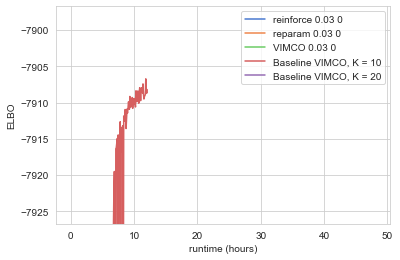

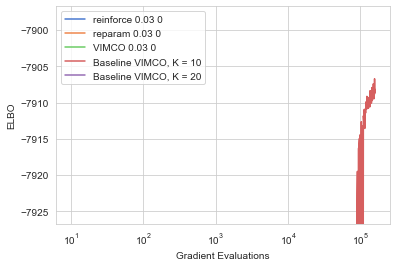

In [412]:
legend = []
for model in ["reinforce","reparam","VIMCO"]:
    plt.plot(np.cumsum(optims[model].run_times)/3600,optims[model].ELBO_ests)
    legend.append(model+" "+str(settings[model][0])+" "+str(settings[model][1]))

for bs in ["10","20"]:
    ELBO_max = max(ELBO_max,max(VBPI_lbs[bs]))
    plt.plot(np.cumsum(VBPI_runtimes[bs])/3600,VBPI_lbs[bs])
    legend.append("Baseline VIMCO, K = %s"%(bs))  

plt.xlabel("runtime (hours)")
plt.ylabel("ELBO")
plt.legend(legend)
plt.ylim([ELBO_min-10,ELBO_max+10])
plt.savefig('../plt/'+data_set+'/'+data_set+'_ELBO_v_time.png')
plt.ylim([ELBO_max-20,ELBO_max+10])
plt.savefig('../plt/'+data_set+'/'+data_set+'_ELBO_v_time_zoom.png')
plt.show()

##############

legend = []
for model in ["reinforce","reparam","VIMCO"]:
    plt.plot(optims[model].epochs,optims[model].ELBO_ests)
    legend.append(model+" "+str(settings[model][0])+" "+str(settings[model][1]))

for bs in ["10","20"]:
    plt.plot(VBPI_iters[bs],VBPI_lbs[bs])
    legend.append("Baseline VIMCO, K = %s"%(bs))  

plt.xlabel("Gradient Evaluations")
plt.ylabel("ELBO")
plt.legend(legend)

plt.xscale('log')
    
plt.ylim([ELBO_min-10,ELBO_max+10])
plt.savefig('../plt/'+data_set+'/'+data_set+'_ELBO_v_iter.png')
plt.ylim([ELBO_max-20,ELBO_max+10])
plt.savefig('../plt/'+data_set+'/'+data_set+'_ELBO_v_iter_zoom.png')
plt.show()

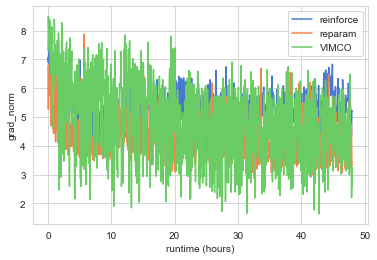

In [413]:
legend = []
    
for model in ["reinforce","reparam","VIMCO"]:
                
        plt.plot(np.cumsum(optims[model].run_times)/3600,np.log(optims[model].grad_norms))
        legend.append(model)

plt.xlabel("runtime (hours)")
plt.ylabel("grad_norm")
plt.legend(legend)
plt.savefig('../plt/'+data_set+'/'+data_set+'_grad_norm_v_time.png')

# draw the random tree using a newick file

In [414]:
def write_newick(node):

    if node.children == []:
        return species[next(iter(node.leaves))] + ":" + str(node.parent.coal_time.item())
    elif node.parent is None:
        return "(" + write_newick(node.children[0]) + "," + write_newick(node.children[1]) + ")"
    else:
        bl = node.parent.coal_time.item() - node.coal_time.item()
        return "(" + write_newick(node.children[0]) + "," + write_newick(node.children[1]) + "):" + str(bl)

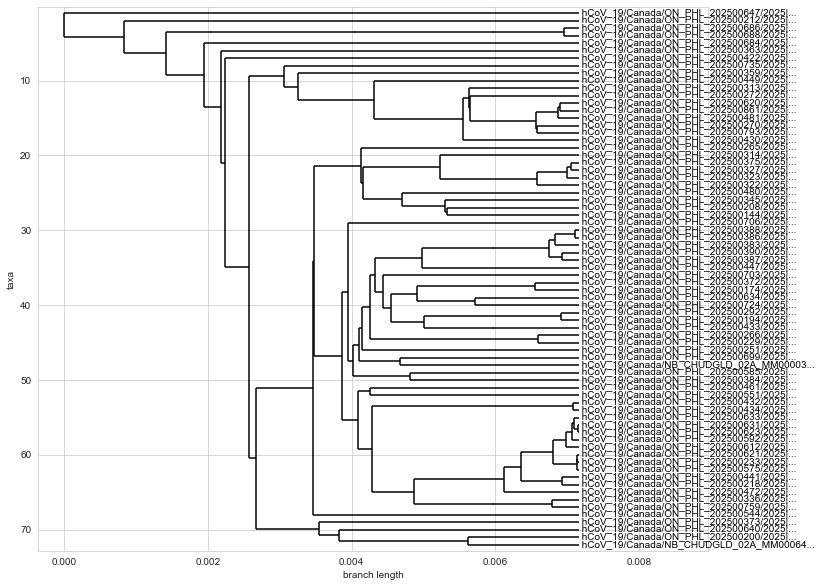

tensor(-7495.9725)
tensor(-114.8570)
tensor(-7610.8295)


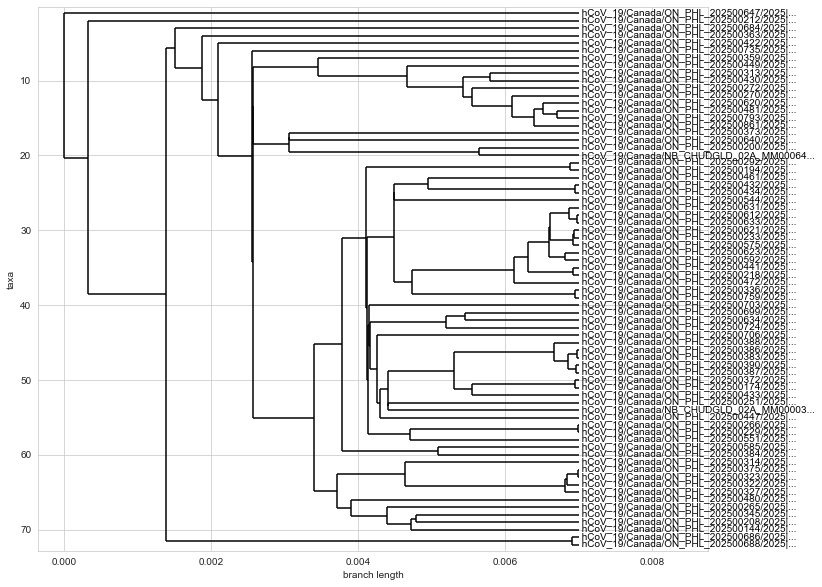

tensor(-7500.1823)
tensor(-114.8050)
tensor(-7614.9873)


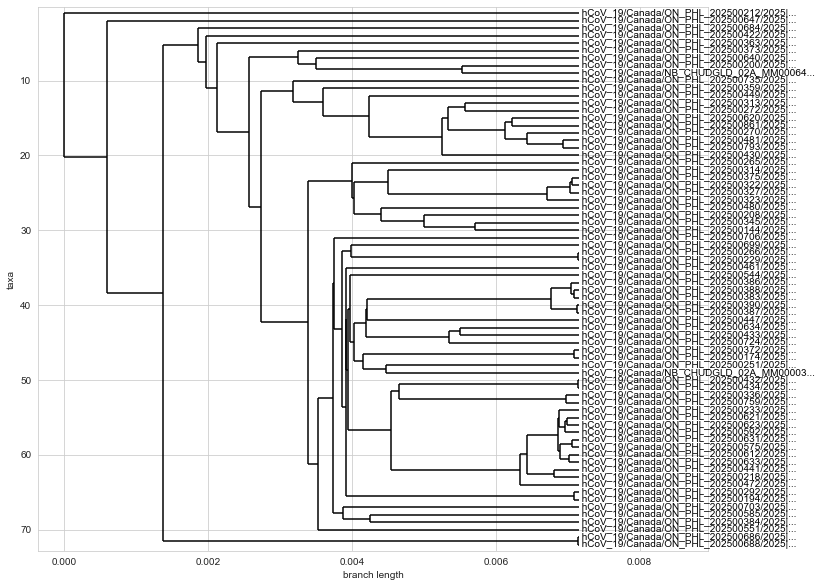

tensor(-7473.7613)
tensor(-114.8868)
tensor(-7588.6481)


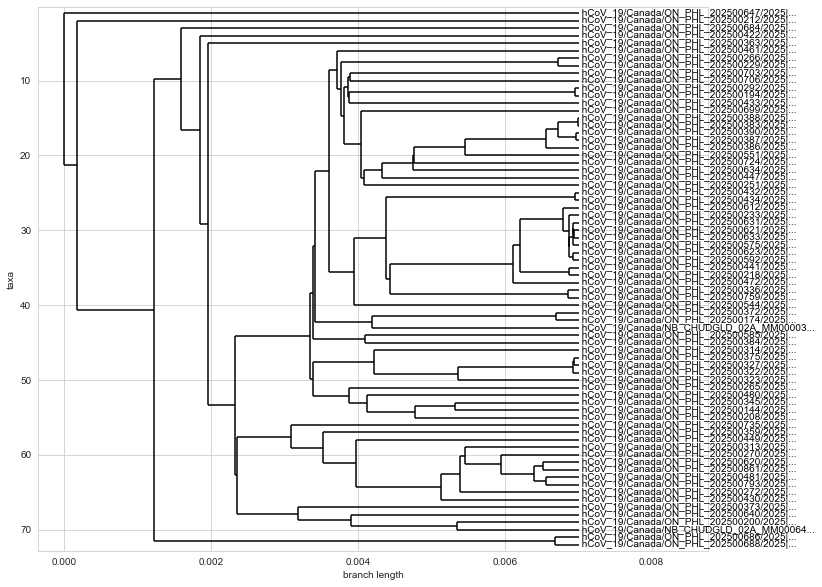

tensor(-7484.7563)
tensor(-114.8965)
tensor(-7599.6528)


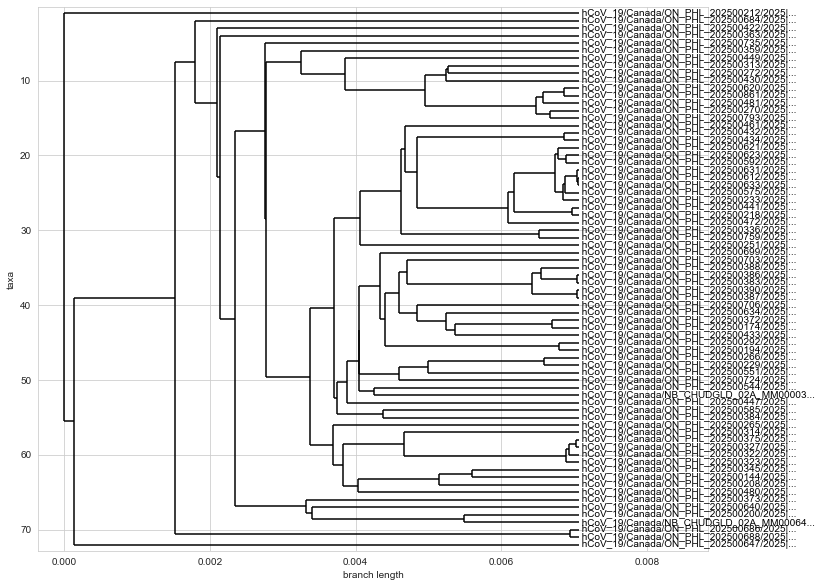

tensor(-7486.8149)
tensor(-114.8593)
tensor(-7601.6741)


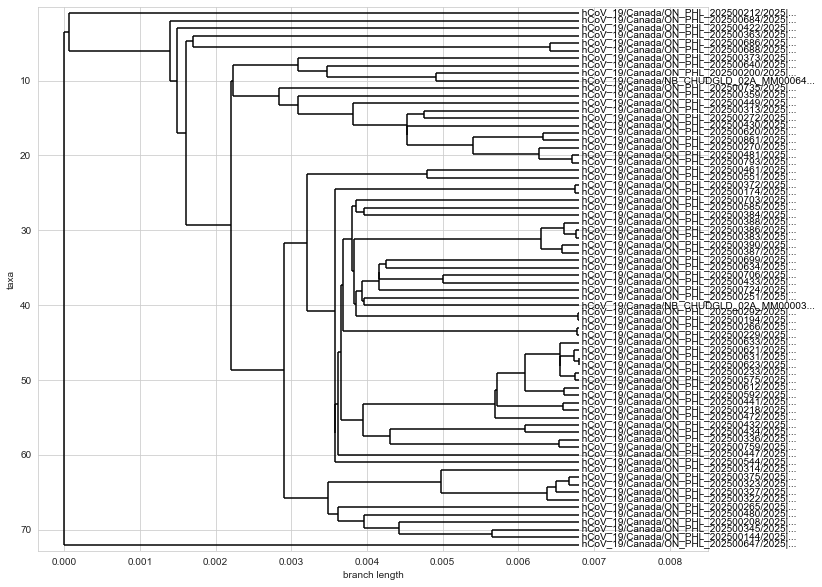

tensor(-7499.8519)
tensor(-114.9014)
tensor(-7614.7534)


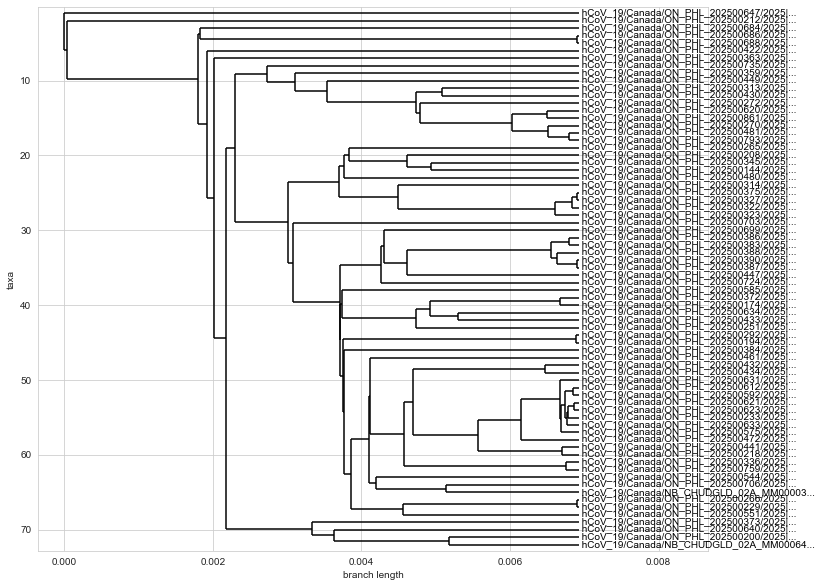

tensor(-7487.0465)
tensor(-114.8662)
tensor(-7601.9127)


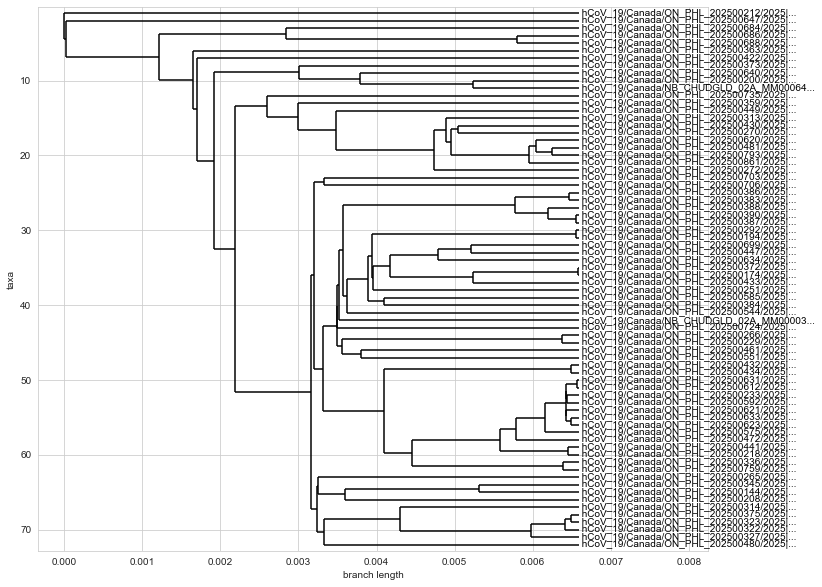

tensor(-7496.3563)
tensor(-114.8676)
tensor(-7611.2240)


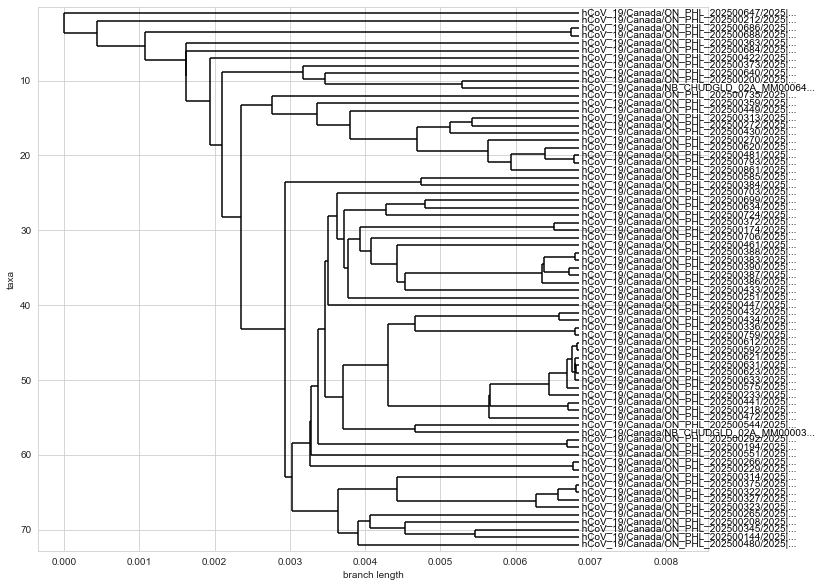

tensor(-7492.6758)
tensor(-114.8832)
tensor(-7607.5591)


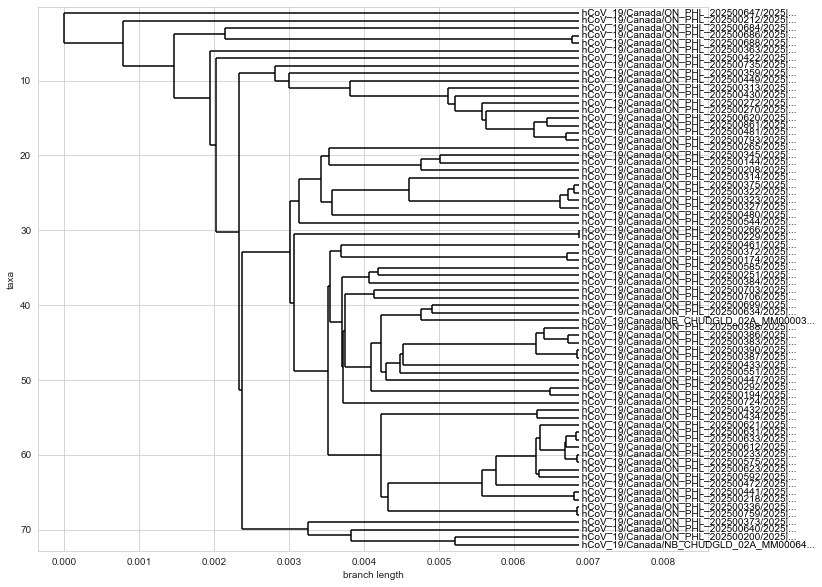

tensor(-7491.1013)
tensor(-114.8926)
tensor(-7605.9939)


In [415]:
theta = torch.tensor(optims['VIMCO'].theta)

with open(data_file, 'rb') as f:
    DS = pickle.load(f)

genomes = []
species = []
for key in DS:
    genomes.append(DS[key])
    species.append(key)
    
n_species = len(species)

# From https://github.com/zcrabbit/vbpi-torch/blob/ff86cf0c47a5753f5cc5b4dfe0b6ed783ab22669/unrooted/phyloModel.py#L7-L11
nuc2vec = {'A':[1.,0.,0.,0.], 'G':[0.,1.,0.,0.], 'C':[0.,0.,1.,0.], 'T':[0.,0.,0.,1.],
           '-':[1.,1.,1.,1.], '?':[1.,1.,1.,1.], 'N':[1.,1.,1.,1.], 'R':[1.,1.,0.,0.],
           'Y':[0.,0.,1.,1.], 'S':[0.,1.,1.,0.], 'W':[1.,0.,0.,1.], 'K':[0.,1.,0.,1.],
           'M':[1.,0.,1.,0.], 'B':[0.,1.,1.,1.], 'D':[1.,1.,0.,1.], 'H':[1.,0.,1.,1.],
           'V':[1.,1.,1.,0.], '.':[1.,1.,1.,1.], 'U':[0.,0.,0.,1.], 'n':[1.,1.,1.,1.]}

for key in list(nuc2vec):
    nuc2vec[key.lower()] = nuc2vec[key]

tree_log_probs = torch.tensor([[nuc2vec[g] for g in genome] for genome in genomes],
                                dtype = torch.float64)
tree_log_probs = torch.log(tree_log_probs)

for _ in range(10):
    Z = torch.normal(mean=0.0,std=1.0,size=(n_species,n_species))
    log_times = torch.exp(theta[1])*Z+theta[0]
    log_times = log_times + torch.triu(torch.full((n_species,n_species), float("Inf")))
    log_times = log_times.detach()

    tree = Tree(theta,log_times,tree_log_probs,
                pop_size=pop_size)


    treedata = write_newick(tree.nodes[-1])
    handle = StringIO(treedata)
    tree_to_draw = Phylo.read(handle, "newick")

    # Set up the plot
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(1, 1, 1)

    # Draw the phylogenetic tree
    Phylo.draw(tree_to_draw, axes=ax)

    print(tree.log_like)
    print(tree.log_prior)
    print(tree.log_p)

# plot estimated ELBO over time

In [416]:
tree_lengths = {}
root_heights = {}
log_likes = {}
log_priors = {}
log_qs = {}
p_qs = {}

# Get data from BEAST

In [417]:
# get lengths from BEAST
tree_lengths["BEAST"] = BEAST_data.treeLength[BEAST_data.state > BEAST_burnin].to_numpy()
root_heights["BEAST"] = BEAST_data['treeModel.rootHeight'][BEAST_data.state > BEAST_burnin].to_numpy()
log_likes["BEAST"] = BEAST_data.likelihood[BEAST_data.state > BEAST_burnin].to_numpy()
log_priors["BEAST"] = BEAST_data.prior[BEAST_data.state > BEAST_burnin].to_numpy()

# Get data from VBPI

In [418]:
self = VBPI_models["10"]
n_runs = 1000
n_particles = 1

root_heights["VBPI"] = []
tree_lengths["VBPI"] = []
log_priors["VBPI"] = []
log_likes["VBPI"] = []
p_qs["VBPI"] = []

for i in range(n_runs):
    print(i)
    with torch.no_grad():
        samp_trees = [self.tree_model.sample_tree() for particle in range(n_particles)]
        [namenum(tree, self.taxa) for tree in samp_trees]
        logq_tree = torch.stack([self.logq_tree(tree) for tree in samp_trees])

        samp_branch, logq_height, height, event_info = self.branch_model(samp_trees)
        log_clock_rate, logq_clock_rate = self.clock_model.sample(n_particles=n_particles)
        samp_branch = samp_branch.to(torch.float32) * log_clock_rate.exp()
        logll = torch.stack([self.phylo_model.loglikelihood(branch, tree) for branch, tree in zip(*[samp_branch, samp_trees])])

        self.tree_prior_model.update_batch(height, event_info)
        coalescent_param, logq_prior = self.tree_prior_model.sample_pop_size(n_particles=n_particles)
        logp_coalescent_prior, _ = self.tree_prior_model(coalescent_param, False)

        logp_clock_rate = self.clock_model(log_clock_rate)

        # get values
        root_heights["VBPI"].extend(list(height[:,0].numpy()))
        tree_lengths["VBPI"].extend(list(np.sum(samp_branch.numpy(),axis=1)))
        log_priors["VBPI"].extend(list(logp_coalescent_prior.numpy() + logp_clock_rate))
        log_likes["VBPI"].extend(list(logll.numpy()))
        p_qs["VBPI"].append(torch.logsumexp(logll + logp_coalescent_prior + logp_clock_rate - logq_tree - logq_height - logq_prior - logq_clock_rate - math.log(n_particles), 0).item())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

# Get data from my code

In [419]:
def get_tree_length(tree):
    tree_length = 0
    for leaf in tree.leaves:
        tree_length += leaf.parent.coal_time.item() - leaf.coal_time

    for node in tree.nodes[:-1]:
        tree_length += node.parent.coal_time.item() - node.coal_time.item()
        
    return tree_length

In [420]:
import gc
n_exp = 1000
n_particles = 1

for model in ["reinforce","reparam","VIMCO"]:
    with torch.no_grad():
        theta = optims[model].theta

        root_heights[model] = []
        tree_lengths[model] = []
        log_priors[model] = []
        log_likes[model] = []
        p_qs[model] = []

        for i in range(n_exp):
            print(i)
            p_minus_qs = []

            for j in range(n_particles):

                Z = torch.normal(mean=0.0,std=1.0,size=(n_species,n_species))
                log_times = torch.exp(theta[1])*Z+theta[0]
                log_times = log_times + torch.triu(torch.full((n_species,n_species), float("Inf")))
                
                tree_log_probs0 = deepcopy(tree_log_probs)
                tree = Tree(theta,log_times,tree_log_probs0,
                            pop_size=pop_size)
                
                p_minus_qs.append(tree.log_p.item() - tree.log_q.item())

                log_likes[model].append(tree.log_like.item())
                log_priors[model].append(tree.log_prior.item())
                root_heights[model].append(tree.nodes[-1].coal_time.item())
                tree_lengths[model].append(get_tree_length(tree))
                
                del tree

            p_qs[model].append(logsumexp(p_minus_qs) - np.log(n_particles))
            
        gc.collect()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380


# Recreate Figure 9 from Zhang et al (2024)

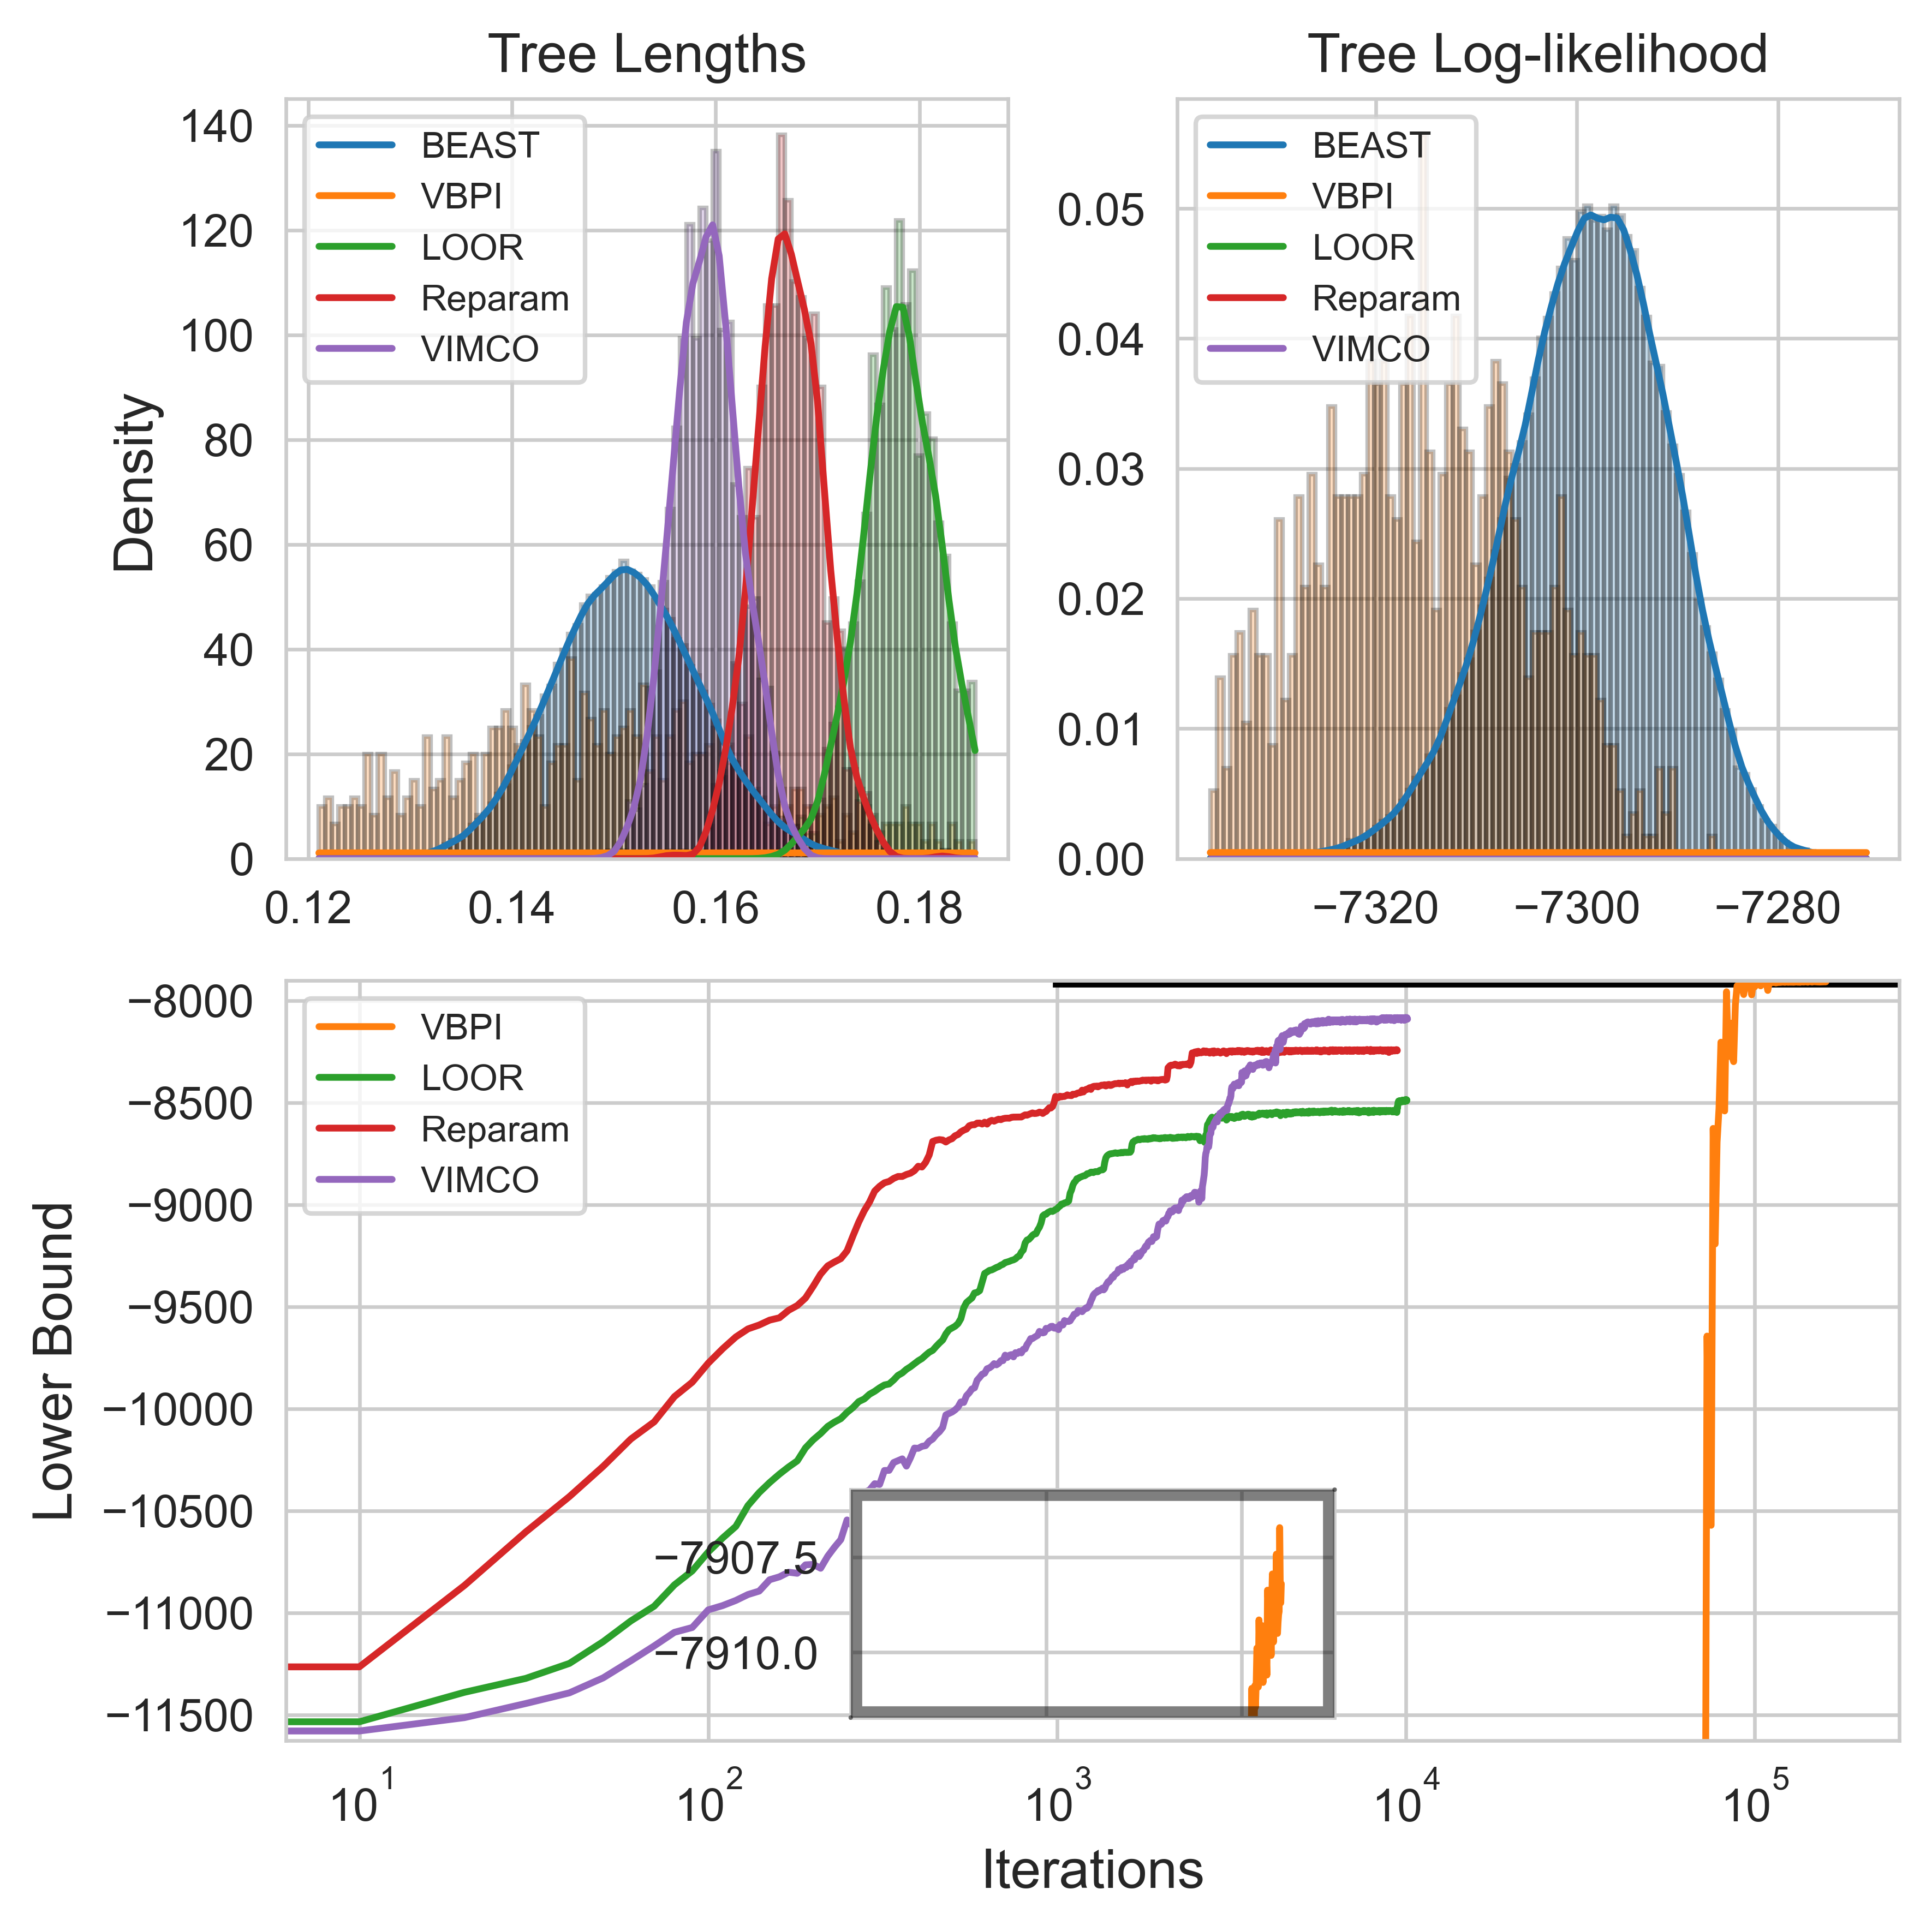

In [421]:
fig, axes = plt.subplots(2, 2, figsize=(6, 6), dpi = 600)

colors = {"BEAST":plt.cm.tab10(0),
          "VBPI":plt.cm.tab10(1),
          "reinforce":plt.cm.tab10(2),
          "reparam":plt.cm.tab10(3),
          "VIMCO":plt.cm.tab10(4)}

keys = list(["BEAST","VBPI","reinforce","reparam","VIMCO"])

### ELBO over time ###

plt.subplot(2,1,2)

plt.plot(VBPI_iters["10"],
         VBPI_lbs["10"],
         color = colors["VBPI"])

plt.plot(optims["reinforce"].epochs,
         optims["reinforce"].ELBO_ests,
         color = colors["reinforce"])

plt.plot(optims["reparam"].epochs,
         optims["reparam"].ELBO_ests,
         color = colors["reparam"])

plt.plot(optims["VIMCO"].epochs,
         optims["VIMCO"].ELBO_ests,
         color = colors["VIMCO"])

plt.xlabel("Iterations",fontsize = 12)
plt.ylabel("Lower Bound",fontsize = 12)

ELBO_max = max(max(VBPI_lbs["10"]),
               max(optims["reinforce"].ELBO_ests),
               max(optims["reparam"].ELBO_ests),
               max(optims["VIMCO"].ELBO_ests))
ELBO_min = min(min(VBPI_lbs["10"]),
               min(optims["reinforce"].ELBO_ests),
               min(optims["reparam"].ELBO_ests),
               min(optims["VIMCO"].ELBO_ests))

plt.ylim(min(min(optims["reinforce"].ELBO_ests),
             max(VBPI_lbs["10"]))-5,
         ELBO_max+5)
plt.legend(["VBPI","LOOR","Reparam","VIMCO"],prop={'size': 8})
plt.xscale('log')
zoom_region = (1000, 300000)  # Specify the region to zoom in
plt.gca().add_patch(plt.Rectangle((zoom_region[0], ELBO_max-5), zoom_region[1] - zoom_region[0], 6,
                                   edgecolor="black", facecolor="none", lw=2))

# Define the inset
axins = inset_axes(plt.gca(), width="30%", height="30%", loc="lower center")
axins.plot(VBPI_iters["10"],
           VBPI_lbs["10"],
           color = colors["VBPI"])

axins.plot(optims["reinforce"].epochs,
           optims["reinforce"].ELBO_ests,
           color = colors["reinforce"])

plt.plot(optims["reparam"].epochs,
         optims["reparam"].ELBO_ests,
         color = colors["reparam"])

plt.plot(optims["VIMCO"].epochs,
         optims["VIMCO"].ELBO_ests,
         color = colors["VIMCO"])

# Set inset limits and labels
axins.set_xlim(zoom_region)
axins.set_xscale('log')
axins.set_xticklabels([])
axins.set_ylim([ELBO_max-5,ELBO_max+1])


# Add a rectangle to indicate the zoomed region
plt.gca().indicate_inset_zoom(axins, edgecolor="black", lw=5)


### Tree lengths ###

plt.subplot(2,2,1)
data = {k: tree_lengths[k] for k in ["BEAST","VBPI","reinforce","reparam","VIMCO"]}
title = "Tree Lengths"
i = 0

_, bins, _ = plt.hist(data[keys[0]], bins = 100, edgecolor='black', alpha = 0.25, 
                      density=True, color=colors[keys[0]])
density = gaussian_kde(data[keys[0]])
density_vals = density(bins)
plt.plot(bins, density_vals, linestyle='-', color=colors[keys[0]])

for key in keys[1:]:
    plt.hist(data[key], bins = bins, edgecolor='black', alpha = 0.25, 
             density=True, color=colors[key])
    density = gaussian_kde(data[key])
    density_vals = density(bins)
    plt.plot(bins, density_vals, linestyle='-', color=colors[key])

plt.legend(["BEAST","VBPI","LOOR","Reparam","VIMCO"],prop={'size': 8})

plt.title(title)
plt.ylabel("Density",fontsize = 12)

### log-likelihooods ###

plt.subplot(2,2,2)
data = {k: log_likes[k] for k in ["BEAST","VBPI","reinforce","reparam","VIMCO"]}
title = "Tree Log-likelihood"
i = 1

_, bins, _ = plt.hist(data[keys[0]], bins = 100, edgecolor='black', alpha = 0.25, 
                      density=True, color=colors[keys[0]])
density = gaussian_kde(data[keys[0]])
density_vals = density(bins)
plt.plot(bins, density_vals, linestyle='-', color=colors[keys[0]])

for key in keys[1:]:
    plt.hist(data[key], bins = bins, edgecolor='black', alpha = 0.25, 
             density=True, color=colors[key])
    density = gaussian_kde(data[key])
    density_vals = density(bins)
    plt.plot(bins, density_vals, linestyle='-', color=colors[key])

plt.legend(["BEAST","VBPI","LOOR","Reparam","VIMCO"],prop={'size': 8})

plt.title(title)
#plt.ylabel("Density")

plt.tight_layout()
plt.savefig('../plt/'+data_set+'/'+data_set+'_hist.png')
plt.show()

In [422]:
def plot_hist(data,title):  
    
    plt.figure(figsize=(3, 3), dpi=80)
    
    colors = {"BEAST":plt.cm.tab10(0),
              "VBPI":plt.cm.tab10(1),
              "reinforce":plt.cm.tab10(2)}
    
    keys = list(data.keys())
    _, bins, _ = plt.hist(data[keys[0]], bins = 100, edgecolor='black', alpha = 0.25, 
                          density=True, color=colors[keys[0]])
    
    # Calculate the estimated density
    density = gaussian_kde(data[keys[0]])
    density_vals = density(bins)
    plt.plot(bins, density_vals, linestyle='-', color=colors[keys[0]])

    for key in keys[1:]:
        plt.hist(data[key], bins = bins, edgecolor='black', alpha = 0.25, 
                 density=True, color=colors[key])
        density = gaussian_kde(data[key])
        density_vals = density(bins)
        plt.plot(bins, density_vals, linestyle='-', color=colors[key])

    plt.legend(["BEAST","VBPI","LOOR"])
    
    plt.title(title)
    plt.ylabel("Density")
    plt.savefig('../plt/'+data_set+'/'+data_set+'_'+title+'_hist.png')
    plt.show()

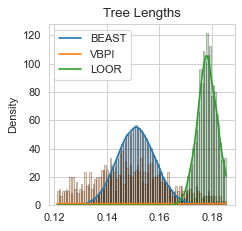

In [423]:
plot_hist({k: tree_lengths[k] for k in ["BEAST","VBPI","reinforce"]},"Tree Lengths")

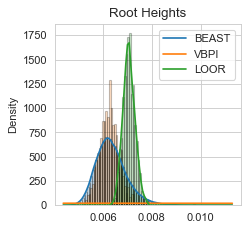

In [424]:
plot_hist({k: root_heights[k] for k in ["BEAST","VBPI","reinforce"]},"Root Heights")

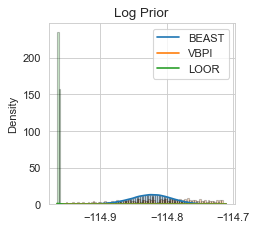

In [425]:
plot_hist({k: log_priors[k] for k in ["BEAST","VBPI","reinforce"]},"Log Prior")

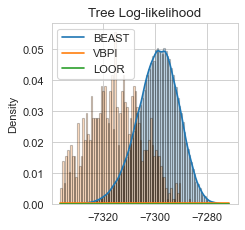

In [426]:
plot_hist({k: log_likes[k] for k in ["BEAST","VBPI","reinforce"]},"Tree Log-likelihood")

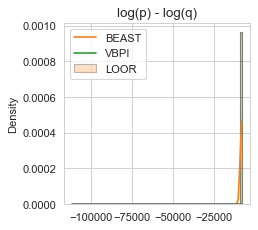

In [427]:
plot_hist({k: p_qs[k] for k in ["VBPI","reinforce"]},"log(p) - log(q)")

In [428]:
# get bootstrap standard error of our models
def ELBO_se(p_qs):
    
    ELBO_hats = []
    
    for _ in range(1000):
        boot_sample = np.random.choice(p_qs,size=len(p_qs),replace=True)
        boot_ELBO = np.mean(boot_sample)
        ELBO_hats.append(boot_ELBO)
        
    return np.std(ELBO_hats,ddof=1)

def MLL_se(p_qs):
    
    MLL_hats = []
    
    for _ in range(1000):
        boot_sample = np.random.choice(p_qs,size=len(p_qs),replace=True)
        boot_MLL = logsumexp(boot_sample) - np.log(len(boot_sample))
        MLL_hats.append(boot_MLL)
        
    return np.std(MLL_hats,ddof=1)

MLLs:

VBPI: -7902.1741373381665
reinforce: -8479.391329185539
reparam: -8234.968664541972
VIMCO: -8077.691229588795

ELBO:

VBPI: -8052.50104581808
reinforce: -8489.707411389212
reparam: -8244.533858193516
VIMCO: -8087.634014087593


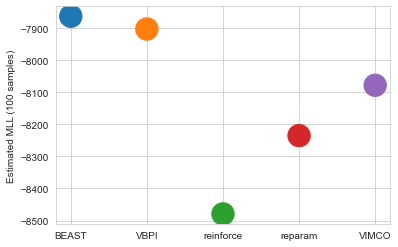

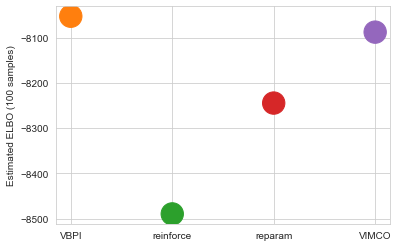

In [429]:
data = {'model': ["BEAST"] + [key for key in p_qs], 
        'MLL': [np.mean(BEAST_MLLs)] + [logsumexp(p_qs[key]) - np.log(len(p_qs[key])) for key in p_qs],
        'MLL_se': [np.std(BEAST_MLLs,ddof=1)] + [MLL_se(p_qs[key]) for key in p_qs],
        'ELBO': [np.nan] + [np.mean(p_qs[key]) for key in p_qs],
        'ELBO_se': [np.nan] + [ELBO_se(p_qs[key]) for key in p_qs]}
df = pd.DataFrame(data)

print("MLLs:")
print("")
for i,key in enumerate(p_qs):
    print("%s: %s"%(key,data['MLL'][i+1]))

print("")
print("ELBO:")
print("")
for i,key in enumerate(p_qs):
    print("%s: %s"%(key,data['ELBO'][i+1]))

# Save the DataFrame to a CSV file
df.to_csv('../plt/'+data_set+'/'+data_set+'_MLLs.csv', index=False)

plt.scatter(data["model"],data["MLL"],c=[colors[key] for key in colors],s=500)
plt.ylabel("Estimated MLL (100 samples)")
plt.savefig('../plt/'+data_set+'/'+data_set+'_MLLs.png')
plt.show()

plt.scatter(data["model"],data["ELBO"],c=[colors[key] for key in colors],s=500)
plt.ylabel("Estimated ELBO (100 samples)")
plt.savefig('../plt/'+data_set+'/'+data_set+'_ELBOs.png')

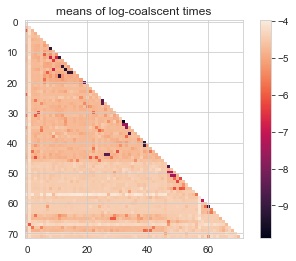

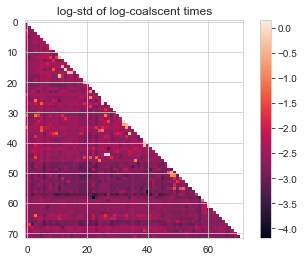

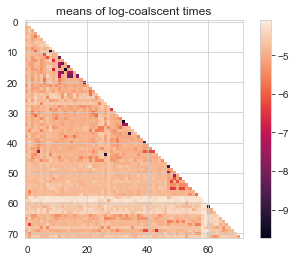

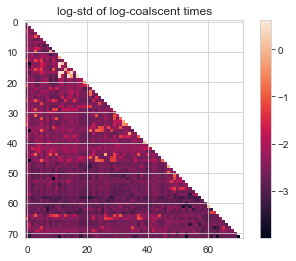

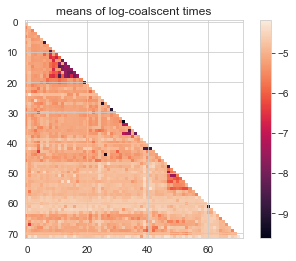

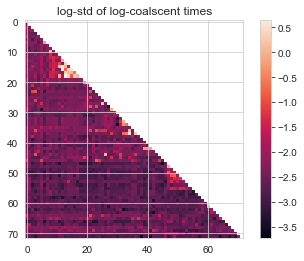

In [430]:
for theta in [optims["reparam"].theta,
              optims["reinforce"].theta,
              optims["VIMCO"].theta]:
    
    m = deepcopy(theta[0].detach())
    m[np.triu_indices(m.shape[0])] = np.nan
    plt.imshow(m)
    plt.title("means of log-coalscent times")
    plt.colorbar()
    plt.show()

    log_sig = deepcopy(theta[1].detach())
    log_sig[np.triu_indices(log_sig.shape[0])] = np.nan
    plt.imshow(log_sig)
    plt.title("log-std of log-coalscent times")
    plt.colorbar()
    plt.show()